## evaluate_UNET_Selina - Flatfield

In this notebook we apply the previously trained model to a set of images and evaluate the quality of the prediction.

This includes the following steps:

* load the original dataset
* prerpocess the dataset (zero center, normalize to range -1 to 1)
* feed the data to the model
* find the ellipses in the predicted likelihood image
* match pairs of predicted and original ellipses
* calculate quality measures

In [1]:
!ls /tf/results/models/

Unet_0-0-0.h5		       Unet_0-0-4_20200423-075700.h5
Unet_0-0-0_20200411-124102.h5  Unet_0-0-4_20200423-093523.h5
Unet_0-0-1.h5		       Unet_0-0-5_fl_RAda,_20200507-094138.h5
Unet_0-0-1_20200411-120615.h5  Unet_0-0-5_fl_RAdam_20200426-134706.h5
Unet_0-0-1_20200411-122810.h5  Unet_0-0-5_fl_RAdam_20200512-094113.h5
Unet_0-0-1_20200411-132132.h5  Unet_0-0-5_fl_RAdam_20200522-122844.h5
Unet_0-0-1_20200413-105017.h5  Unet_0-0-5_fl_RAdam_20200525-084831.h5
Unet_0-0-2_20200413-190741.h5  Unet_0-0-5_fl_RAdam_20200602-100339.h5
Unet_0-0-3_20200414-144612.h5  Unet_0-0-5_fl_RAdam_20200602-115253.h5
Unet_0-0-4_20200423-064224.h5  Unet_0-0-5_fl_RAdam_20200603-153056.h5
Unet_0-0-4_20200423-070809.h5  Unet_0-0-5_fl_RAdam_20200610-140630.h5
Unet_0-0-4_20200423-070930.h5  Unet_0-0-5_fl_RAdam_20200610-141144.h5
Unet_0-0-4_20200423-071031.h5  Unet_0-0-5_fl_RAdam_20200615-152004.h5
Unet_0-0-4_20200423-071209.h5  Unet_0-0-5_fl_RAdam_20200615-191423.h5
Unet_0-0-4_20200423-071259.h5  Unet_0-0-5_fl_RAdam_20200

In [2]:
import tensorflow as tf
# TODO: remove after tf2.0 migration
# handle tf API changes 1.x to 2.0
from packaging import version
if version.parse(tf.__version__) < version.parse('2.0'):
    opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=opts))
else:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
## check if tf detected a GPU 
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x for x in local_device_protos if x.device_type == 'GPU']



print("GPU device id: ", tf.test.gpu_device_name())
print("GPU details: \n" , get_available_gpus())

1 Physical GPUs, 1 Logical GPUs
GPU device id:  /device:GPU:0
GPU details: 
 [name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 136183808
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14593384120009033203
physical_device_desc: "device: 0, name: Quadro M4000, pci bus id: 0000:65:00.0, compute capability: 5.2"
]


In [3]:
## load the UNet model from UNETmodel.py
# details the the network can be found here: 
from includes.UNETmodel import UNet

# create model takes two arguments, the dimension of the input image (width x height x channels)
# and the number of classes 
# TODO: check if the last activation function is correctly choosen in this implementation!
with tf.device('/cpu:0'):
    #unet = UNet().create_model((540,300,1),1, d=32)
    #unet.load_weights("/tf/results/models/Unet_0-0-1_20200413-105017.h5")
    
    unet = UNet().create_model((720,540,1), 1 , d=8)
    unet.load_weights("/tf/results/models/Unet_0-0-5_fl_RAdam_20200610-141144.h5")

network = 'cell_contours_'

build UNet ...


In [4]:
#### Copied Training setup
from datetime import datetime

test_size = 0.2
random_state = 121
epochs = 100
batch_size = 4
learning_rate = 1e-5
loss = 'binary_crossentropy'
metrics = ['accuracy']
stats = dict(
    name="Unet",
    version="0-0-1",
    date=datetime.now().strftime('%Y%m%d-%H%M%S'),
    data_raw="-".join(["gt_0","gt_3","gt_4","gt_5","gt_6","gt_7","gt_8"]),
    data_split="%d-%d"%(test_size*100, random_state),
    model_path="/tf/results/results/models/",
    model_ext="h5",
    log_path="/tf/results/results/logs/",
    img_path="/tf/results/results/singlePredictions/"
)

## Convert mask to ellipse
There are 2 steps to perform. The first is the conversion from a binary mask to individual object edges. We achieve this by the scikit-image methods **label**, which enumerates the individual patches of objects within the mask.
In the second step we apply the function **regionprops** to the pixel positions of the mask edge pixels.

In [5]:
from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import binary_erosion
import cv2

def fit_ellipses_regionprops(p):
    labeled = label(p)
    out = []
    for region in regionprops(labeled,p):  
        a = region.major_axis_length / 2
        b = region.minor_axis_length / 2
        r = np.sqrt(a * b)
        circum = np.pi * ((3 * (a + b)) - np.sqrt(10 * a * b + 3 * (a**2 + b**2)))
        if region.area >= 300: #analyze only regions larger than 300 pixels
        #if region.area >= Amin_pixels:
            fit = ((region.centroid[0],region.centroid[1]),(region.minor_axis_length,region.major_axis_length),90 - np.rad2deg(-region.orientation))
            out.append(fit)
    return out

In [113]:
def preprocess(img):
    return (img - np.mean(img)) / np.std(img).astype(np.float32)

## Show results for individual image
We apply the network to the image with the number "id" in the clickpoints database.
We plot the original image, the predicted likelihood, the human expert mask and the prediction mask.<br>
We alpha overlay this with the fitted ellipses from the prediction mask image in red.

In [7]:
# load the training images and masks
# MAIN PROCESSING LOOP
# load the training images and masks
import os
import imageio
import numpy as np
import clickpoints
from matplotlib.path import Path

# TODO do we export all images or just the ones with ellipsoids? might be good as negative samples?

search_path = '../results/cell_contours/evaluate'
file_list = []
for root, dirs, files in os.walk(search_path):
    for file in files:
        if not file.endswith(".cdb"):
            continue
        file_list.append(os.path.abspath(os.path.join(root, file)))

images = []
masks = []

num_cells = 0
images_total = 0
        
for cdb_file in file_list:
    cdb = clickpoints.DataFile(cdb_file)

    # Get polygons of every image
    q_poly = cdb.getPolygons()
    img_ids = np.unique([pol.image.id for pol in q_poly])
    print("#%d found" % q_poly.count())
    
    print("#%d images" % len(img_ids))
    
    
    
    # How many images in cdb
    q_img = cdb.getImages()
    ids = np.unique([el.id for el in q_img])
    print("#%d images" % len(ids))
    images_total += len(ids)

    nx, ny = 540,720
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T

            
    #Masks for every image if you want to evaluate on not just the positives.
    for id in ids:
     # get image object by id and image data
        img_o = cdb.getImage(id=id)
        img   = img_o.get_data()
        # img = img/im_av
        if len(img.shape) == 3:
            img = img[:,:,0]
            
        # apply pre processing and append to list 
        images.append(np.array(preprocess(img))[:,:,None])
        
        mask = np.zeros((img.shape[0:2]), dtype=np.uint8)
        if id in img_ids:
        # get ellipses in this image 
            q_polys=cdb.getPolygons(image=img_o)
            mask = np.zeros((np.shape(img_o)[0:2]), dtype=np.uint8)
            for pol in q_polys:
                if np.shape(pol)[0] != 0:
                    num_cells += 1
                    polygon = np.array([[pol.points]])
                    path = Path(polygon.squeeze())
                    grid = path.contains_points(points)
                    grid = grid.reshape((ny,nx))
                    mask += grid
        masks.append(mask)

# convert lists to arrays, expand to network expetation of [N x w x h x c]
images = np.array(images)
masks = np.array(masks)[:,:,:,None]

print(images.shape)
print(masks.shape)

no openslide found
path /tf/results/cell_contours/evaluate/gt_2_ben.cdb
Open database with version 22
#371 found
#226 images
#500 images
(500, 720, 540, 1)
(500, 720, 540, 1)


178.52745627572017 -2.7719938827184154e-16
79 -4.15632625403824
243 2.692412085801734


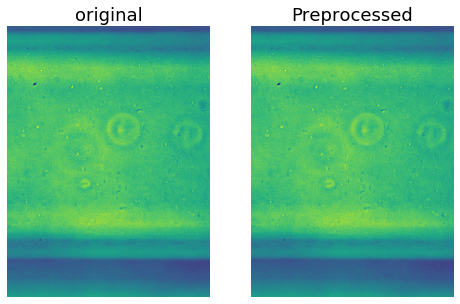

In [124]:
id = 44
fig, axes = plt.subplots(1,2,figsize=[8,5],)
ax=axes[0]
ax.set_title("original")
ax.imshow(img.squeeze())
ax.set_axis_off()

ax=axes[1]
ax.set_title("Preprocessed")
ax.imshow(preprocess(img.squeeze()))
ax.set_axis_off()

img_o = cdb.getImage(id=id)
img   = img_o.get_data()

print(np.mean(img), np.mean(preprocess(img)))
print(np.min(img), np.min(preprocess(img)))
print(np.max(img), np.max(preprocess(img)))

(720, 540, 1)


(720, 540)

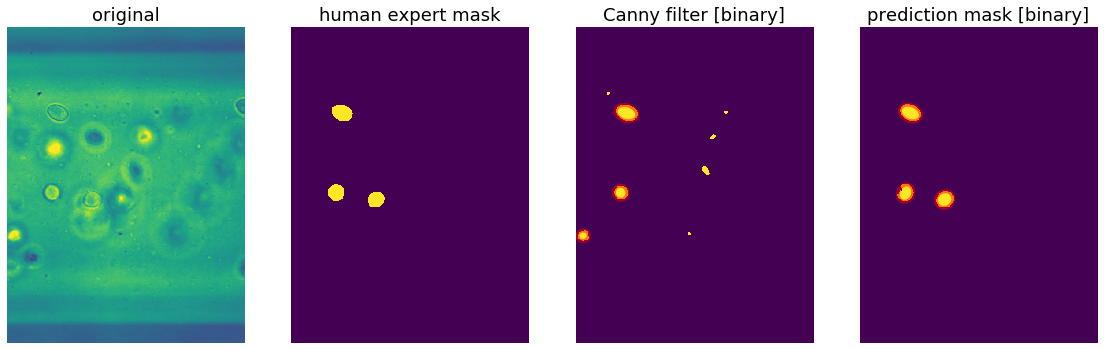

In [106]:
id=13
# z.B. 2 von Netzwerk erkannt, nicht von Canny

with tf.device('/cpu:0'):
    prediction=unet.predict(images[id:id+1])
    
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

#Canny-filter
from skimage import feature
from scipy.ndimage import morphology
struct = morphology.generate_binary_structure(2, 1)  #structural element for binary erosion


pred = prediction[0]
print(np.shape(pred))

im1o = feature.canny(images[id].squeeze(), sigma=2.5, low_threshold=0.6, high_threshold=0.99, use_quantiles=True) #edge detection           
im2o = morphology.binary_fill_holes(im1o, structure=struct).astype(int) #fill holes
im3o = morphology.binary_erosion(im2o, structure=struct).astype(int) #erode to remove lines and small dirt
ellipses_n = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(im3o)])

fig, axes = plt.subplots(1,4,figsize=[16,5],)
ax=axes[0]
ax.set_title("original")
ax.imshow(images[id].squeeze())
ax.set_axis_off()

ax=axes[1]
ax.set_title("human expert mask")
ax.imshow(masks[id].squeeze())
ax.set_axis_off()

ax=axes[2]
ax.set_title("Canny filter [binary]")
ax.imshow(im3o.squeeze())
ax.set_axis_off()

for ell in fit_ellipses_regionprops(im3o.squeeze()):
    xy, (a,b), phi = ell
    e = Ellipse([xy[1],xy[0]], width=b,height=a, angle=-phi, fill=False, edgecolor = 'red',linestyle='-' ,linewidth=4)
    ax.add_artist(e)
    e.set_alpha(0.5)
    e.set_facecolor((1.,0.,0.))
    #e.set_edgecolor(('r'))

ax=axes[3]
ax.set_title("prediction mask [binary]")
ax.imshow(pred.squeeze()>0.5)
ax.set_axis_off()

for ell in fit_ellipses_regionprops(prediction.squeeze()>0.5):
    xy, (a,b), phi = ell
    e = Ellipse([xy[1],xy[0]], width=b,height=a, angle=-phi, fill=False, edgecolor = 'red',linestyle='-',linewidth=4)
    ax.add_artist(e)
    e.set_alpha(0.5)
    e.set_facecolor((1.,0.,0.))
    #e.set_edgecolor(('r'))
    #print(np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(prediction.squeeze()>0.5)]))

plt.tight_layout()    
plt.savefig('/tf/results/results_new/'  + 'performance_C_N_' + network + '.png')
np.shape(prediction.squeeze())

'not_normalized'

## Apply to all images
We apply the network to all images. Most of the code is handling of file paths and Database entries to get the prediction to the correct img. The actual ellipse prediction for raw image **img** is:
```python
prediction_mask =unet.predict(img[None,:,:,0,None].astype(np.float32)/255.).squeeze()>0.5
ellipses_n = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses(prediction_mask)])
```
We match the predicted ellipses to the original ones, enabling us to calculate evaluation metrics. For this we use the euclidian distance between a **ground truth** (manual acquired) ellipse and a **system** (redicted by network + regionprops) ellipse center as the cost of matching this pair. We match via the **linear_sum_assignment** function implemented in scipy, which builts up on the "hungarian algorithm" by Kuhn and Munkres [Kuhn55].<br>
We save the predicted and ground truth ellipses in one clickpoints database. The pairs of matched ellipses get the same text annotation with one image wise id. The unmatched ground truth ellipses get another id, the unmatched system ellipses get a "x".

The ellipse parameters are additionaly stored in arrays for the neural network, the Canny algorithm, as well as the ground truth and separate arrays for matched ellipses.
<br><br>
H. W. Kuhn (1955): The Hungarian method for the assignment problem. Naval Research Logistics Quarterly 2, S. 83–97.

In [1]:
import copy
import matplotlib.pyplot as plt
import imageio

# flatfield is not used
def getFlatfield_video(video):
    if True:
        vidcap = imageio.get_reader(video) 
        print("compute average (flatfield) image") 
        count = 0
        for image in vidcap:
            if len(image.shape) == 3:
                image = image[:,:,0]
            if count == 0:
                im_av = copy.deepcopy(image)   
                im_av = np.asarray(im_av) 
                im_av.astype(float)
            else:
                im_av = im_av + image.astype(float) 
            count += 1 
        im_av = im_av / np.mean(im_av)
        #np.save(flatfield, im_av)
        plt.imshow(im_av)
    return im_av

In [11]:
import os
import clickpoints
import numpy as np
from scipy.optimize import linear_sum_assignment

#Canny-filter
from skimage import feature
from scipy.ndimage import morphology
struct = morphology.generate_binary_structure(2, 1)  #structural element for binary erosion

search_path = '../results/cell_contours/evaluate' #Change this path and also cdb path!
file_list = []
for root, dirs, files in os.walk(search_path):
    for file in files:
        if not file.endswith(".cdb"):
            continue
        file_list.append(os.path.abspath(os.path.join(root, file)))
        
# all cdb files with images and ellipses

GT = []  # Manually acquired ellipses
GTMatch = []  # Ground truth ellipses with matching ellipses
GTMatchR = []
SysMatch = []  # Canny ellipses with matching ellipses
SysMatchR = []  # System ellipses (regionprops) with matching ellipses
Sys = []  # By canny acquired
SysR = []  # By system acquired (regionprops)
id_Sys = []  #  ids of images with predicted ellipses 
id_SysR = []
SysMatch_comp = []  # comparison between regionprops and fitEllipse
SysMatchR_comp = []

Sys_new = []
SysR_new = []

Cost = []

len_tot = 0

nx, ny = 540,720
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T


for cdb_file in file_list:
    cdb = clickpoints.DataFile(cdb_file)
    
    # Create new cdb
    cdb_file_new = cdb_file.replace("/evaluate/", "/clickpoints/")
    os.makedirs(os.path.split(cdb_file_new)[0], exist_ok=True)
    cdb_new = clickpoints.DataFile(cdb_file_new, "w")

    # Fit ellipses to GT, Canny and Network
    ellipseO_type = cdb_new.setMarkerType(name="GT", color="#FCE205",mode=clickpoints.DataFile.TYPE_Ellipse) #yellow
    ellipseN_type = cdb_new.setMarkerType(name="Canny", color="#00FF00",mode=clickpoints.DataFile.TYPE_Ellipse) #green
    ellipseR_type = cdb_new.setMarkerType(name="Network", color="#0AFFE0",mode=clickpoints.DataFile.TYPE_Ellipse) #turquois

    # Mask for network prediction
    mask_type = cdb_new.setMaskType(name="prediction_mask",color='#0000FF') #blau
    
    # Polygon for new cdb
    polygon_type = cdb_new.setMarkerType(name='GT_polygons',color='#FF0000',mode=clickpoints.DataFile.TYPE_Polygon) #red

    # get the image ids which contain at least on ellipse # in ground truth
    q_poly = cdb.getPolygons()
    print("#%d found" % q_poly.count())
    img_ids = np.unique([el.image.id for el in q_poly])
    
    # How many images in cdb
    q_img = cdb.getImages()
    ids = np.unique([i.id for i in q_img])
    print("#%d images" % len(ids))
    
    #print(len(ids))
    len_tot += len(ids)
    for id in ids:
        # get image object by id and image data
        img_o = cdb.getImage(id=id)
        path = cdb_new.getPath(path_string=".", create=True)     
        img_n = cdb_new.setImage(path=path, filename=img_o.filename, frame=img_o.frame)
        
        img   = img_o.get_data()
        if len(img.shape) == 3:
            img = img[:,:,0]
        
        with tf.device('/cpu:0'):
            im = preprocess(img[None,:,:,None])
            prediction_mask = unet.predict(im).squeeze()>0.5
            ellipses_r = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(prediction_mask)])
            #print('Canny')
            im1o = feature.canny(img.squeeze(), sigma=2.5, low_threshold=0.6, high_threshold=0.99, use_quantiles=True) #edge detection           
            im2o = morphology.binary_fill_holes(im1o, structure=struct).astype(int) #fill holes
            im3o = morphology.binary_erosion(im2o, structure=struct).astype(int) #erode to remove lines and small dirt
            ellipses_n = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(im3o)])
        
        cdb_new.setMask(image=img_n, data=prediction_mask.astype(np.uint8))    
        Sys.extend(ellipses_n)
        SysR.extend(ellipses_r)
        
        # get polygons in this image 
        if id in img_ids:
            mask = np.zeros((img.shape[0:2]), dtype=np.uint8)
            q_polys=cdb.getPolygons(image=img_o)
            #cdb_new.setPolygons(image=img_n,points=q_polys.points,type=polygon_type)            
            mask = np.zeros((np.shape(img_o)[0:2]), dtype=np.uint8)
            for pol in q_polys:
                if np.shape(pol)[0] != 0:
                    num_cells += 1
                    
                    cdb_new.setPolygon(image=img_n, points=pol.points,type=polygon_type)    

                    polygon = np.array([pol.points])
                    path = Path(polygon.squeeze())
                    grid = path.contains_points(points)
                    grid = grid.reshape((ny,nx))
                    mask += grid

            ellipses_o = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(mask)])
            GT.extend(ellipses_o)
            
            ### Try matching with GT ###
            #print('GT and prediction comparison')           
            if ellipses_o.shape[0]!= 0 and ellipses_r.shape[0] != 0:    
                costR = np.linalg.norm(ellipses_o[None,:,:2]-ellipses_r[:,None,:2], axis=-1)
                sys_ids_r, gt_ids_r = linear_sum_assignment(costR)     

                gt_texts_r = np.array(["%d"%i for i in range(len(ellipses_o))])
                sys_texts_r = np.array(["x" for i in range(len(ellipses_r))])            

                # costR has to be under a certain value. To assign the correct ellipse!!
                index = []
                for i in range(len(sys_ids_r)):
                    if costR[sys_ids_r[i],gt_ids_r[i]] > 50:
                        #print('Here R')
                        #print(sys_ids_r,gt_ids_r, costR)
                        index.append(i)
                sys_ids_r = np.delete(sys_ids_r,index)
                gt_ids_r = np.delete(gt_ids_r,index)
                #print(sys_ids_r,gt_ids_r)

                sys_texts_r[sys_ids_r] = np.array(["%d"%i for i in gt_ids_r])

                GTMatchR.extend(ellipses_o[gt_ids_r])
                SysMatchR.extend(ellipses_r[sys_ids_r])
                id_SysR.append(id)
                cdb_new.setEllipses(image=img_n,
                                x=ellipses_r[:,0],
                                y=ellipses_r[:,1],
                                width=ellipses_r[:,2],
                                height=ellipses_r[:,3],
                                angle=ellipses_r[:,4],
                                type=ellipseR_type,
                                text=sys_texts_r)
                
            ### Try matching with GT ###
            #print('GT and Canny comparison')
            if ellipses_o.shape[0]!= 0 and ellipses_n.shape[0] != 0: # so no ellipse at all in image
                cost = np.linalg.norm(ellipses_o[None,:,:2]-ellipses_n[:,None,:2], axis=-1)
                sys_ids, gt_ids = linear_sum_assignment(cost)
        
                gt_texts = np.array(["%d"%i for i in range(len(ellipses_o))])
                sys_texts = np.array(["x" for i in range(len(ellipses_n))])
            
                # Avoiding mismatch if there is no corresponding system ellipse to ground truth ellipse
                index = []
                for i in range(len(sys_ids)):
                    if cost[sys_ids[i],gt_ids[i]] > 50:
                    #print('Here')
                        index.append(i)
                        Cost.append(cost)
                    #print(sys_ids,gt_ids, cost)
                    else:
                        Cost.append(cost)

                sys_ids = np.delete(sys_ids,index)
                gt_ids = np.delete(gt_ids,index)
            
                sys_texts[sys_ids] = np.array(["%d"%i for i in gt_ids])

                #print(sys_ids,gt_ids)
            
                GTMatch.extend(ellipses_o[gt_ids])
                SysMatch.extend(ellipses_n[sys_ids])

                id_Sys.append(id)
                # New predicted ellipse in cdb
                cdb_new.setEllipses(image=img_n,
                            x=ellipses_n[:,0],
                            y=ellipses_n[:,1],
                            width=ellipses_n[:,2],
                            height=ellipses_n[:,3],
                            angle=ellipses_n[:,4],
                            type=ellipseN_type,
                            text=sys_texts)
            # write gt ellipses into cdb
            if ellipses_o.shape[0]!= 0:
                try:
                    cdb_new.setEllipses(image=img_n,
                            x=ellipses_o[:,0],
                            y=ellipses_o[:,1],
                            width=ellipses_o[:,2],
                            height=ellipses_o[:,3],
                            angle=ellipses_o[:,4],
                            type=ellipseO_type,
                            text=gt_texts_r)
                except:
                    cdb_new.setEllipses(image=img_n,
                            x=ellipses_o[:,0],
                            y=ellipses_o[:,1],
                            width=ellipses_o[:,2],
                            height=ellipses_o[:,3],
                            angle=ellipses_o[:,4],
                            type=ellipseO_type)
            
        else:
            if ellipses_r.shape[0] != 0:
                cdb_new.setEllipses(image=img_n,
                                x=ellipses_r[:,0],
                                y=ellipses_r[:,1],
                                width=ellipses_r[:,2],
                                height=ellipses_r[:,3],
                                angle=ellipses_r[:,4],
                                type=ellipseR_type)
            if ellipses_n.shape[0] != 0:
                cdb_new.setEllipses(image=img_n,
                                x=ellipses_n[:,0],
                                y=ellipses_n[:,1],
                                width=ellipses_n[:,2],
                                height=ellipses_n[:,3],
                                angle=ellipses_n[:,4],
                                type=ellipseN_type)

GT=np.array(GT)

# Matched ellipses with fitEllipse
GTMatch=np.array(GTMatch)
Sys=np.array(Sys)
SysMatch=np.array(SysMatch)

# Matched ellipses with regionprops
GTMatchR=np.array(GTMatchR)
SysR=np.array(SysR)
SysMatchR=np.array(SysMatchR)

print('finished!')

path /tf/results/cell_contours/evaluate/gt_2_ben.cdb
Open database with version 22
path /tf/results/cell_contours/clickpoints/gt_2_ben.cdb
#371 found
#500 images
finished!


In [12]:
print(np.shape(GT))
print('GT and Canny')
print(np.shape(GTMatch))
print(np.shape(Sys))
print(np.shape(SysMatch))
print('GT and Network')
print(np.shape(GTMatchR))
print(np.shape(SysR))
print(np.shape(SysMatchR))

print()
print(len_tot)

(369, 5)
GT and Canny
(251, 5)
(1119, 5)
(251, 5)
GT and Network
(329, 5)
(457, 5)
(329, 5)

500


## Measure quality of prediction
We measure the discrepancy between the matched pairs of ellipses in all 5 ellipse attributes: center X position, center Y position, long semiaxis, short semiaxis and skew angle.

## Canny edge detection

In [135]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

c=GTMatch[:,2]/GTMatch[:,3]
a = np.array([[np.min(c),np.max(c)]])
im = ax.imshow(a,cmap='viridis')

# Change to have some appendix to the figures later on
network = 'cell_contours_new_'
addition = '_test_2'

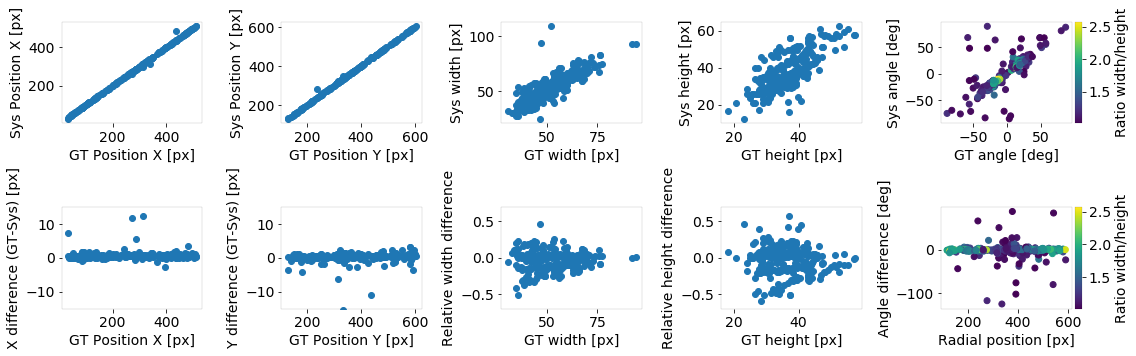

In [136]:
fig, axes = plt.subplots(2,5,figsize=[16,5],)
axes=np.array(axes)

ax = axes[0,0]
ax.scatter(GTMatch[:,0],SysMatch[:,0])
ax.set_xlabel("GT Position X [px]")
ax.set_ylabel("Sys Position X [px]")

ax = axes[0,1]

ax.scatter(GTMatch[:,1],SysMatch[:,1])
ax.set_xlabel("GT Position Y [px]")
ax.set_ylabel("Sys Position Y [px]")

ax = axes[0,2]
ax.scatter(GTMatch[:,2], SysMatch[:,2])
#ax.set_xlim(30,85)
ax.set_xlabel("GT width [px]")
ax.set_ylabel("Sys width [px]")

ax = axes[0,3]
ax.scatter(GTMatch[:,3], SysMatch[:,3])
#ax.set_xlim(20,65)
ax.set_xlabel("GT height [px]")
ax.set_ylabel("Sys height [px]")

ax = axes[0,4]
gt_phi = ((GTMatch[:,4]-90*(GTMatch[:,2]<GTMatch[:,3])+90)%360 -90) - ((((GTMatch[:,4]-90*(GTMatch[:,2]<GTMatch[:,3])+90)%360 -90)>180)) * 180
sys_phi = (SysMatch[:,4]+90)%180 -90
ax.scatter(gt_phi, sys_phi, c=GTMatch[:,2]/GTMatch[:,3])
ax.set_xlabel("GT angle [deg]")
ax.set_ylabel("Sys angle [deg]")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Ratio width/height')

# Normalisation of x and y position:  

ax = axes[1,0]
ax.scatter(GTMatch[:,0],(GTMatch[:,0]-SysMatch[:,0]))
ax.set_ylim(-15,15)
ax.set_xlabel("GT Position X [px]")
ax.set_ylabel("X difference (GT-Sys) [px]")

ax = axes[1,1]
ax.scatter(GTMatch[:,1],(GTMatch[:,1]-SysMatch[:,1]))
ax.set_ylim(-15,15)
ax.set_xlabel("GT Position Y [px]")
ax.set_ylabel("Y difference (GT-Sys) [px]")

ax = axes[1,2]
ax.scatter(GTMatch[:,2], (GTMatch[:,2]-SysMatch[:,2])/GTMatch[:,2])
ax.set_ylim(-0.7,0.7)
#ax.set_xlim(30,85)
ax.set_xlabel("GT width [px]")
ax.set_ylabel("Relative width difference")

ax = axes[1,3]
ax.scatter(GTMatch[:,3], (GTMatch[:,3]-SysMatch[:,3])/GTMatch[:,3])
ax.set_ylim(-0.7,0.7)
#ax.set_xlim(20,65)
ax.set_xlabel("GT height [px]")
ax.set_ylabel("Relative height difference")

ax = axes[1,4]
gt_phi = ((GTMatch[:,4]-90*(GTMatch[:,2]<GTMatch[:,3])+90)%360 -90) - ((((GTMatch[:,4]-90*(GTMatch[:,2]<GTMatch[:,3])+90)%360 -90)>180)) * 180
sys_phi = (SysMatch[:,4]+90)%180 -90
radial_position = 720 - GTMatch[:,1]
ax.scatter(radial_position, (gt_phi-sys_phi), c=GTMatch[:,2]/GTMatch[:,3])
ax.set_xlabel("Radial position [px]")
ax.set_ylabel("Angle difference [deg]")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Ratio width/height')

fig.tight_layout()

plt.savefig('/tf/results/results_new/Parameters/' + '_GT_vs_Canny' + addition + '.png')

In [137]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

c=GTMatchR[:,2]/GTMatchR[:,3]
a = np.array([[np.min(c),np.max(c)]])
im = ax.imshow(a,cmap='viridis')

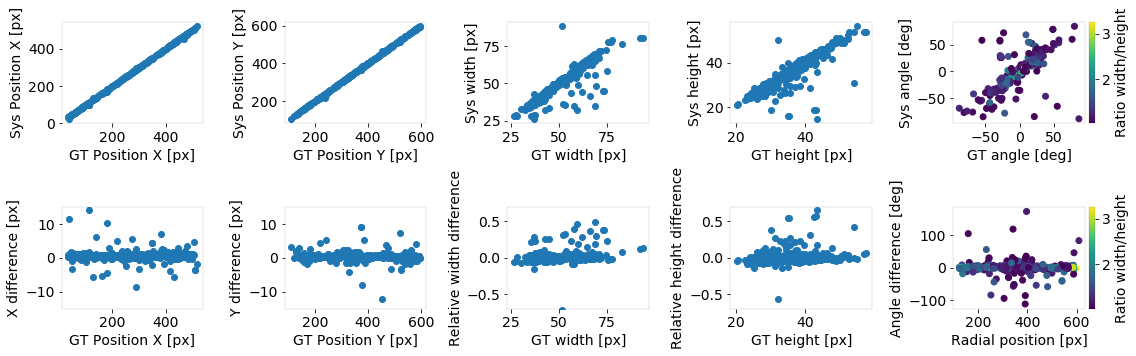

In [138]:
fig, axes = plt.subplots(2,5,figsize=[16,5],)
axes=np.array(axes)

ax = axes[0,0]
ax.scatter(GTMatchR[:,0],SysMatchR[:,0])
ax.set_xlabel("GT Position X [px]")
ax.set_ylabel("Sys Position X [px]")

ax = axes[0,1]
ax.scatter(GTMatchR[:,1],SysMatchR[:,1])
ax.set_xlabel("GT Position Y [px]")
ax.set_ylabel("Sys Position Y [px]")

ax = axes[0,2]
ax.scatter(GTMatchR[:,2], SysMatchR[:,2])
ax.set_xlabel("GT width [px]")
ax.set_ylabel("Sys width [px]")

ax = axes[0,3]
ax.scatter(GTMatchR[:,3], SysMatchR[:,3])
ax.set_xlabel("GT height [px]")
ax.set_ylabel("Sys height [px]")

ax = axes[0,4]
gt_phi = ((GTMatchR[:,4]-90*(GTMatchR[:,2]<GTMatchR[:,3])+90)%360 -90) - ((((GTMatchR[:,4]-90*(GTMatchR[:,2]<GTMatchR[:,3])+90)%360 -90)>180)) * 180
sys_phi = (SysMatchR[:,4]+90)%180 -90
ax.scatter(gt_phi, sys_phi, c=GTMatchR[:,2]/GTMatchR[:,3])
ax.set_xlabel("GT angle [deg]")
ax.set_ylabel("Sys angle [deg]")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Ratio width/height')

ax = axes[1,0]
ax.scatter(GTMatchR[:,0],(GTMatchR[:,0]-SysMatchR[:,0]))
ax.set_ylim(-15,15)
ax.set_xlabel("GT Position X [px]")
ax.set_ylabel("X difference [px]")

ax = axes[1,1]
ax.scatter(GTMatchR[:,1],(GTMatchR[:,1]-SysMatchR[:,1]))
ax.set_ylim(-15,15)
ax.set_xlabel("GT Position Y [px]")
ax.set_ylabel("Y difference [px]")

ax = axes[1,2]
ax.scatter(GTMatchR[:,2], (GTMatchR[:,2]-SysMatchR[:,2])/GTMatchR[:,2])
ax.set_ylim(-0.7,0.7)
ax.set_xlabel("GT width [px]")
ax.set_ylabel("Relative width difference")

ax = axes[1,3]
ax.scatter(GTMatchR[:,3], (GTMatchR[:,3]-SysMatchR[:,3])/GTMatchR[:,3],) 
ax.set_ylim(-0.7,0.7)
ax.set_xlabel("GT height [px]") 
ax.set_ylabel("Relative height difference")

ax = axes[1,4]
gt_phi = ((GTMatchR[:,4]-90*(GTMatchR[:,2]<GTMatchR[:,3])+90)%360 -90) - ((((GTMatchR[:,4]-90*(GTMatchR[:,2]<GTMatchR[:,3])+90)%360 -90)>180)) * 180
sys_phi = (SysMatchR[:,4]+90)%180 -90
radial_position = 720 - GTMatchR[:,1]
ax.scatter(radial_position, (gt_phi-sys_phi), c=GTMatchR[:,2]/GTMatchR[:,3],cmap='viridis')
ax.set_xlabel("Radial position [px]")
ax.set_ylabel("Angle difference [deg]")
#fig.colorbar(np.array([np.min(GTMatchR[:,2]/GTMatchR[:,3]),np.max(GTMatchR[:,2]/GTMatchR[:,3])]), ax=axes[:,4])
#fig.colorbar()

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Ratio width/height')

fig.tight_layout()
plt.savefig('/tf/results/results_new/Parameters/' + 'GT_vs_Sys_R' + addition + '.png')

X Position difference: 0.64 +- 3.74
Y Position difference: -0.01 +- 3.38
Width Position difference: -1.87 +- 7.80
Height Position difference: -1.49 +- 6.63
Angle Position difference: -169.42 +- 183.40


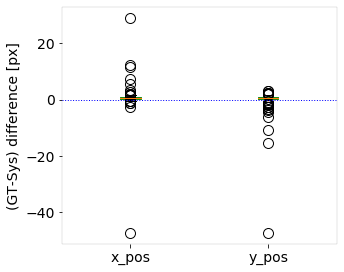

In [68]:
addition = 'not_normalized'
x_pos_diff = (GTMatch[:,0]-SysMatch[:,0])
y_pos_diff = (GTMatch[:,1]-SysMatch[:,1])
width_diff = (GTMatch[:,2]-SysMatch[:,2])
height_diff = (GTMatch[:,3]-SysMatch[:,3])
angle_diff = (SysMatch[:,4]+90)%180 -90 - ((GTMatch[:,4]-90*(GTMatch[:,2]<GTMatch[:,3])+90)%360 -90) - ((((GTMatch[:,4]-90*(GTMatch[:,2]<GTMatch[:,3])+90)%360 -90)>180)) * 180

font = {'family' : 'sans-serif',
        'sans-serif':['Arial'],
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('legend', fontsize=12)
plt.rc('axes', titlesize=18)    
plt.rcParams['axes.linewidth'] = 0.1 #set the value globally

differences = [x_pos_diff,y_pos_diff,width_diff,height_diff]

radius = np.sqrt(GTMatch[:,2] * GTMatch[:,3])
differences_rel = [x_pos_diff/radius,y_pos_diff /radius,width_diff/GTMatch[:,2],height_diff/GTMatch[:,3]]
fig, ax = plt.subplots(figsize=[5,4])
ticks = ['x-pos', 'y-pos','width','height']
line_props = dict(color="r", alpha=0.3)
bbox_props = dict(color="g", alpha=0.9)
flier_props = dict(marker="o", markersize=10)
#ax.set_ylim(-5,5)
plt.boxplot(differences[:2], whiskerprops=line_props, boxprops=bbox_props, flierprops=flier_props)

ax.set_xticklabels(['x_pos', 'y_pos','width','height'])
ax.set_ylabel('(GT-Sys) difference [px]')

plt.axhline(linewidth=1,color='b',linestyle=':')

plt.tight_layout()
#plt.savefig('/tf/results/results_new/Parameters/' + 'box_GT_Sys_x_y' + addition + '.png')

print('X Position difference: %.2f +- %.2f' % (np.mean(x_pos_diff), np.std(x_pos_diff)))
print('Y Position difference: %.2f +- %.2f' % (np.mean(y_pos_diff), np.std(y_pos_diff)))
print('Width Position difference: %.2f +- %.2f' % (np.mean(width_diff), np.std(width_diff)))
print('Height Position difference: %.2f +- %.2f' % (np.mean(height_diff), np.std(height_diff)))
print('Angle Position difference: %.2f +- %.2f' % (np.mean(angle_diff), np.std(angle_diff)))


X Position difference: 0.64 +- 3.74
Y Position difference: -0.01 +- 3.38
Width Position difference: -1.87 +- 7.80
Height Position difference: -1.49 +- 6.63
Angle Position difference: -169.42 +- 183.40


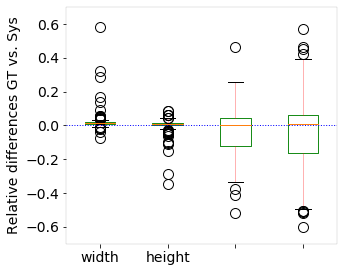

In [65]:
addition = 'not_normalized'

fig, ax = plt.subplots(figsize=[5,4])
ticks = ['width', 'height']
line_props = dict(color="r", alpha=0.3)
bbox_props = dict(color="g", alpha=0.9)
flier_props = dict(marker="o", markersize=10)
ax.set_ylim(-0.7,0.7)
plt.boxplot(differences_rel, whiskerprops=line_props, boxprops=bbox_props, flierprops=flier_props)

ax.set_xticklabels(['width', 'height'])
ax.set_ylabel('Relative differences GT vs. Sys')

plt.axhline(linewidth=1,color='b',linestyle=':')

plt.tight_layout()
#plt.savefig('/tf/results/results_new/Parameters/' + 'box_GT_Sys_w_h' + addition + '.png')

print('X Position difference: %.2f +- %.2f' % (np.mean(x_pos_diff), np.std(x_pos_diff)))
print('Y Position difference: %.2f +- %.2f' % (np.mean(y_pos_diff), np.std(y_pos_diff)))
print('Width Position difference: %.2f +- %.2f' % (np.mean(width_diff), np.std(width_diff)))
print('Height Position difference: %.2f +- %.2f' % (np.mean(height_diff), np.std(height_diff)))
print('Angle Position difference: %.2f +- %.2f' % (np.mean(angle_diff), np.std(angle_diff)))


## Neural network and Regionprops

In [21]:
np.array([np.min(GTMatchR[:,2]/GTMatchR[:,3]),np.max(GTMatchR[:,2]/GTMatchR[:,3])])

array([1.01341459, 3.26279844])

X Position difference: 0.79 +- 2.37
Y Position difference: 0.46 +- 1.92
Width Position difference: 1.19 +- 5.33
Height Position difference: 0.55 +- 3.93
Angle Position difference: -169.42 +- 183.40


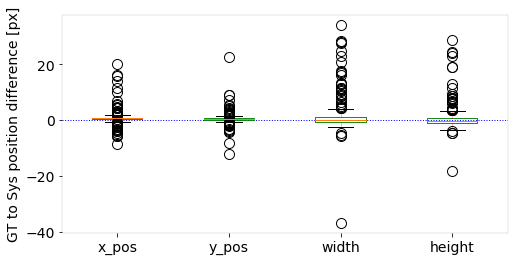

In [66]:
x_pos_diff = (GTMatchR[:,0]-SysMatchR[:,0])
y_pos_diff = (GTMatchR[:,1]-SysMatchR[:,1])
width_diff = (GTMatchR[:,2]-SysMatchR[:,2])
height_diff = (GTMatchR[:,3]-SysMatchR[:,3])
#angle_diff = (SysMatchR[:,4]+90)%180 -90 - ((GTMatchR[:,4]-90*(GTMatchR[:,2]<GTMatchR[:,3])+90)%360 -90) - ((((GTMatchR[:,4]-90*(GTMatchR[:,2]<GTMatchR[:,3])+90)%360 -90)>180)) * 180

differencesR = [x_pos_diff,y_pos_diff,width_diff,height_diff]

radius = np.sqrt(GTMatchR[:,2] * GTMatchR[:,3])
differencesR_rel = [x_pos_diff/radius,y_pos_diff /radius,width_diff/GTMatchR[:,2],height_diff/GTMatchR[:,3]]


fig, ax = plt.subplots(figsize=[8,4])

line_props = dict(color="r", alpha=0.3)
bbox_props = dict(color="g", alpha=0.9)
flier_props = dict(marker="o", markersize=10)
#ax.set_ylim(-0.6,0.6)
ax.set_xticklabels(['x_pos', 'y_pos', 'width', 'height', 'angle'])
ax.set_ylabel('GT to Sys position difference [px]')

#ax2 = fig.add_subplot(111, sharex=ax, frameon=False)
#plt.tick_params(
 #   axis='x',          # changes apply to the x-axis
 #   which='both',      # both major and minor ticks are affected
 #   bottom=False,      # ticks along the bottom edge are off
 #   top=False,         # ticks along the top edge are off
 #   labelbottom=False) # labels along the bottom edge are off
##ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")
#ax2.set_ylim(-20,20)
#ax2.set_ylabel("GT to Sys position difference [degree]")
plt.axhline(linewidth=1,color='b',linestyle=':')


plt.boxplot(differencesR, whiskerprops=line_props, boxprops=bbox_props, flierprops=flier_props)
plt.savefig('/tf/results/results_new/Parameters/' + network + 'boxplot_GT_vs_Sys_R' + addition + '.png')

print('X Position difference: %.2f +- %.2f' % (np.mean(x_pos_diff), np.std(x_pos_diff)))
print('Y Position difference: %.2f +- %.2f' % (np.mean(y_pos_diff), np.std(y_pos_diff)))
print('Width Position difference: %.2f +- %.2f' % (np.mean(width_diff), np.std(width_diff)))
print('Height Position difference: %.2f +- %.2f' % (np.mean(height_diff), np.std(height_diff)))
print('Angle Position difference: %.2f +- %.2f' % (np.mean(angle_diff), np.std(angle_diff)))

## Comparison between Canny and NN+regionprops

One set of Ellipses is fitted with the regionprops algorithm based on the binary masks of the Canny filter and the binary mask of the prediction of the neural network

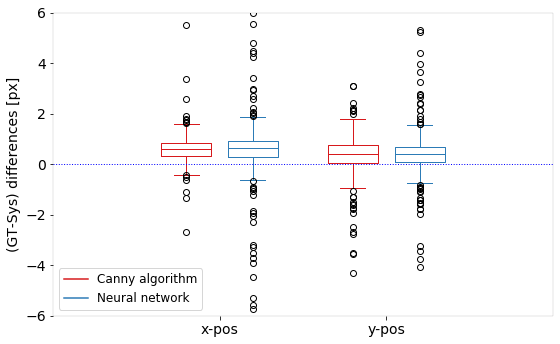

In [85]:
import matplotlib.pyplot as plt
import numpy as np

data_a = differences[:2]
data_b = differencesR[:2]

ticks = ['x-pos', 'y-pos']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

fig, ax = plt.subplots(figsize=[8,5])
bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Canny algorithm')
plt.plot([], c='#2C7BB6', label='Neural network')
plt.legend(loc=3)

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.ylim(-6,6)
plt.axhline(linewidth=1,color='b',linestyle=':')

ax.set_ylabel('(GT-Sys) differences [px]')

plt.tight_layout()
plt.savefig('/tf/results/results_new/Parameters/' + 'boxplot_x_y_' + addition + '.png')

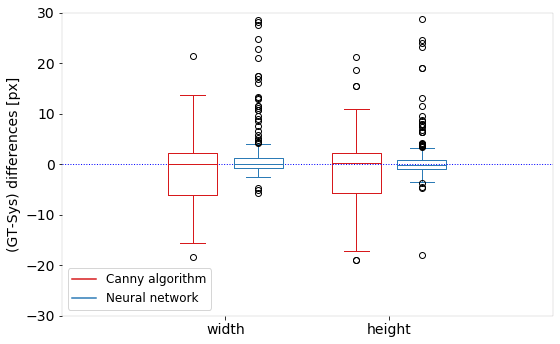

In [154]:
import matplotlib.pyplot as plt
import numpy as np

data_a = differences[2:]
data_b = differencesR[2:]
# change if the relative values are desired
data_c = differences_rel[2:]
data_d = differencesR_rel[2:]

ticks = ['width', 'height']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

fig, ax = plt.subplots(figsize=[8,5])
bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Canny algorithm')
plt.plot([], c='#2C7BB6', label='Neural network')
plt.legend(loc=3)

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.ylim(-30,30)
plt.axhline(linewidth=1,color='b',linestyle=':')

ax.set_ylabel('(GT-Sys) differences [px]')

plt.tight_layout()
plt.savefig('/tf/results/results_new/Parameters/' + 'boxplot_w_h_' + addition + '.png')

## Measure precision and recall

Precision measures the accuracy of the positive predictions.
$$precision = \frac{TP}{TP + FP}$$

Recall measures the sensitivity, i.e. the positive instances that are correctly detected.
$$recall = \frac{TP}{TP + FN}$$

F1-Score combines those two criteria: $$ F_1 = \frac{2\cdot precision \cdot recall}{precision + recall}$$

In [24]:
Trues = np.shape(GT)[0]
TP = np.shape(SysMatch)[0]
FN = np.shape(GT)[0] - TP
FP = np.shape(Sys)[0] - TP + np.shape(Sys_new)[0]

print('total true: {}'.format(Trues))

precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1_score = (2 * precision * recall) / (precision + recall)
print('TP','FN','FP')
print(TP,FN,FP)
print('Canny edge detector: precision = %.4f, recall = %.4f, F1-score = %.4f' % (precision, recall, F1_score))
print()

Trues = np.shape(GT)[0]
TP_R = np.shape(SysMatchR)[0]
FN_R = np.shape(GT)[0] - TP_R
FP_R = np.shape(SysR)[0] - TP_R + np.shape(SysR_new)[0]

print(TP_R,FN_R,FP_R)
precision_R = TP_R / (TP_R + FP_R)
recall_R = TP_R / (TP_R + FN_R)
F1_score_R = (2 * precision_R * recall_R) / (precision_R + recall_R)
print('Neural Network + Regionprops: precision = %.4f, recall = %.4f, F1-score = %.4f' % (precision_R, recall_R, F1_score_R))

total true: 369
TP FN FP
251 118 868
Canny edge detector: precision = 0.2243, recall = 0.6802, F1-score = 0.3374

329 40 128
Neural Network + Regionprops: precision = 0.7199, recall = 0.8916, F1-score = 0.7966


In [25]:
images[id:id+batch_size].shape

(0, 720, 540, 1)

In [26]:
import time

id = 1
batch_size = 1

with tf.device('/cpu:0'):
    t1 = time.perf_counter()
    prediction=unet.predict(images[id:id+batch_size])
    print("CPU elapsed:\t%.2fs for a batch of %d images" % (time.perf_counter()- t1, batch_size))
    
with tf.device('/gpu:0'):
    t1 = time.perf_counter()
    prediction=unet.predict(images[id:id+batch_size])
    print("GPU elapsed:\t%.2fs for a batch of %d images" % (time.perf_counter()- t1, batch_size))   

CPU elapsed:	0.07s for a batch of 1 images


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv1_1/Conv2D (defined at /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_945]

Function call stack:
keras_scratch_graph
